#### The human body is a complex machine that heavily relies on the basic units of life - cells. Cells can be separated into different types, which even undergo transitions during development, under disease or when regenerating. This cellular heterogeneity is reflected in their morphology, function, and gene expression profiles. Strong disruptions causing deregulations of the cell types influence the entire system causing potentially even serious diseases like cancer. It is therefore vital to understand how cells behave in a normal state and under perturbations to improve our understanding of the entire cellular systems.

#### This task is approached in different ways, where potentially the most promising one is to profile cells at the individual level. Compared with the bulk analysis, single cell (sc) analysis stands out with the advantage of cell isolation which allows for studying the existence and behaviors of different cell types. SC also outperforms traditional flow cytometry approach because only a few dozen of markers are present for analysis, insufficient compared to the scale gene expression data from SC. So far, each cells’ transcriptome was primarily examined in a process known as single-cell RNA sequencing. With recent advances in single-cell genomics, it is now possible to enrich the transcriptome information with spatial, chromatin accessibility or protein information. These advances generate not only insight into complex regulatory mechanisms, but also go along with additional complexity for data analysts.

In [1]:
import scanpy as sc
import anndata as ad
import pooch
import os

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

### Load Dataset

The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of healthy human donors and was part of openproblem’s NeurIPS 2021 benchmarking dataset [Luecken et al., 2021]. The data contains 8,785 cells and 36,601 measured genes. We’ll now investigate these with a basic preprocessing and clustering workflow.

In [3]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [ ]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

### Quality Control

#### Filtering low quality cells

When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell. As these cells are usually not the main target of our analysis and might distort our downstream analysis, we are removing them during quality control. For identifying them, we define cell quality control (QC) threshold. Cell QC is typically performed on the following three QC covariates:

- The number of counts per barcode (count depth)
- The number of genes per barcode
- The fraction of counts from mitochondrial genes per barcode

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith('RPS|RPL')
adata.var['hb'] = adata.var_names.str.startswith("^HB[^(P)]")

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

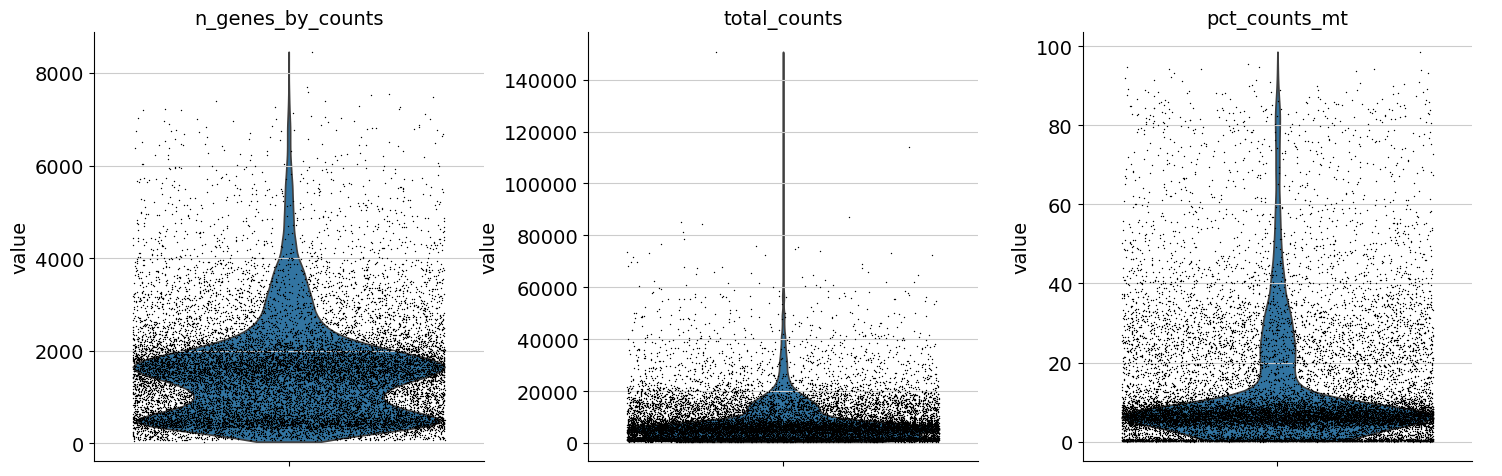

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

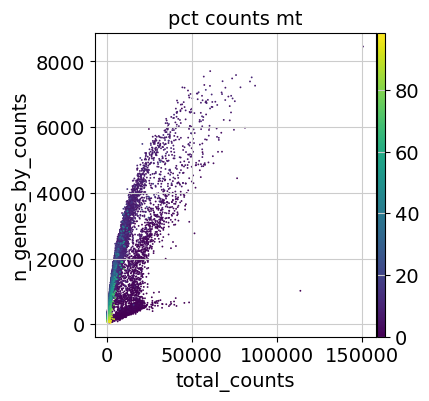

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

#### Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, for example, if they were captured in the same droplet. That’s why we used the term “barcode” instead of “cell” until now. A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods.

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal are typically initial preprocessing steps. Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset. Doublet detection methods are computationally efficient and there exist several software packages for this task.

In [10]:
sc.pp.scrublet(adata, batch_key="sample")

### Normalization

The preprocessing step of “normalization” aims to adjust the raw counts in the dataset for variable sampling effects by scaling the observable variance to a specified range. Several normalization techniques are used in practice varying in complexity. They are mostly designed in such a way that subsequent analysis tasks and their underlying statistical methods are applicable.

A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [11]:
adata.layers["counts"] = adata.X.copy()

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

### Feature Selection

We now have a normalized data representation that still preserves biological heterogeneity but with reduced technical sampling effects in gene expression. Single-cell RNA-seq datasets usually contain up to 30,000 genes and so far we only removed genes that are not detected in at least 20 cells. However, many of the remaining genes are not informative and contain mostly zero counts. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples.

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

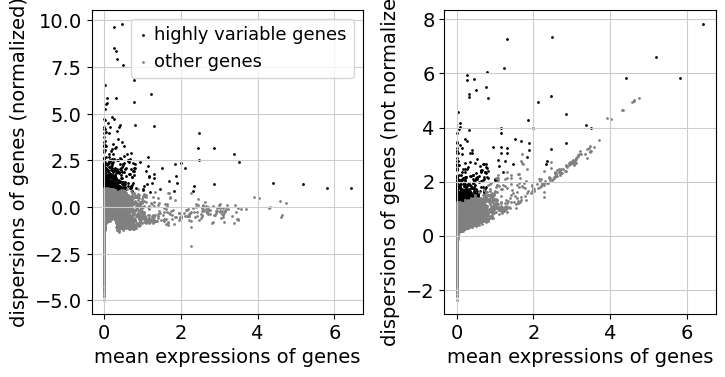

In [14]:
sc.pl.highly_variable_genes(adata)

### Dimensionality Reduction

As previously mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes. This immediately points to the fact that scRNA-seq data suffers from the ‘curse of dimensionality’.

Not all genes are informative and are important for the task of cell type clustering based on their expression profiles. We already aimed to reduce the dimensionality of the data with feature selection, as a next step one can further reduce the dimensions of single-cell RNA-seq data with dimensionality reduction algorithms. These algorithms are an important step during preprocessing to reduce the data complexity and for visualization. Several dimensionality reduction techniques have been developed and used for single-cell data analysis.



#### PCA

In our dataset each cell is a vector of a n_var-dimensional vector space spanned by some orthonormal basis. As scRNA-seq suffers from the ‘curse of dimensionality’, we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy[Grün et al., 2014]. PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

PCA offers the advantage that it is highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [15]:
sc.tl.pca(adata)

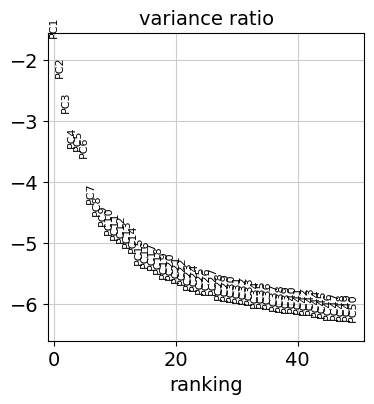

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

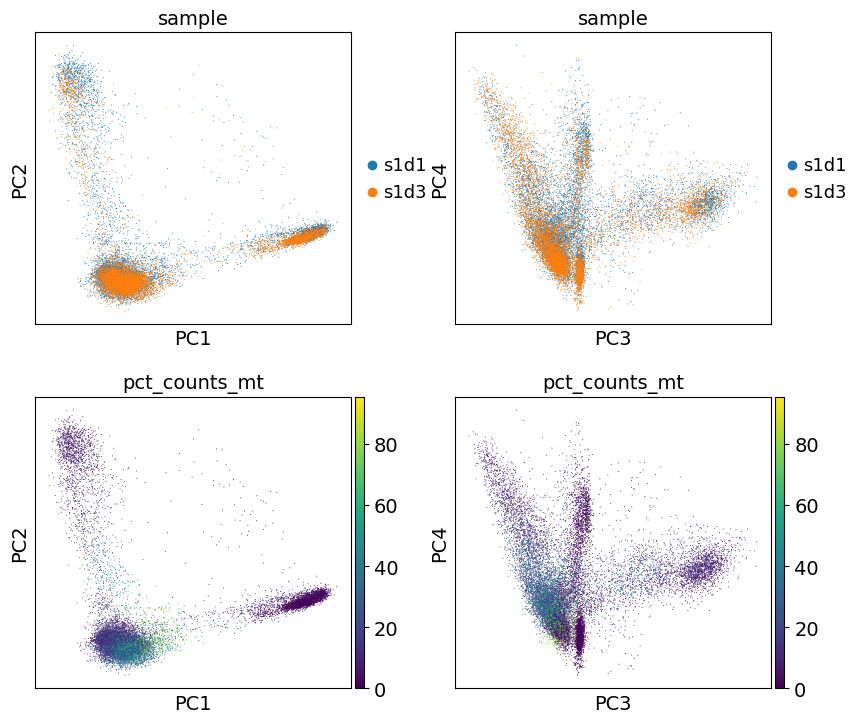

In [17]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

#### t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [18]:
sc.tl.tsne(adata, use_rep="X_pca")

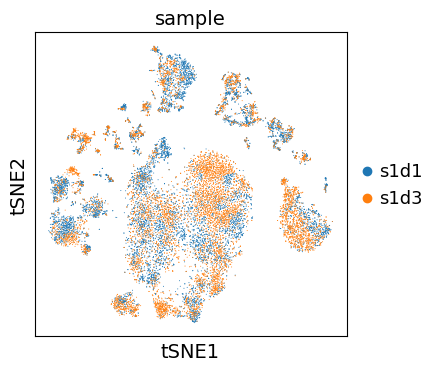

In [19]:
sc.pl.tsne(adata, color="sample", size=2)

#### UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.

We first calculate PCA a neighborhood graph on our data.

In [ ]:
sc.pp.neighbors(adata)

In [21]:
sc.tl.umap(adata)

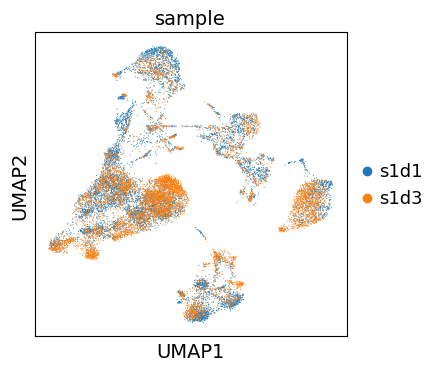

In [22]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

### Discussion
The above results show that UMAP produces equally meaningful representations compared with t-SNE, particularly in its ability to resolve subtly differing cell populations. It also provides the useful and intuitively pleasing feature that it preserves more of the global structure and, notably, the continuity of the cell subsets. UMAP outputs are faster to compute compared with t-SNE. UMAP embeddings are more reproducible than other methods, notably more so than those from t-SNE implementations. We systematically and quantitatively benchmarked all these qualitative aspects. UMAP was found to be the best or close to best method in every aspect investigated, and thus appears as a robust all-around method for dimensionality reduction for single-cell methods. Although this will also be possible with UMAP, the autoencoder scvis currently offers the advantage of being able to append new data points to an existing embedding. The scRNAseq analysis toolkits scanpy20 and Seurat21 recently implemented UMAP as a possible tool for dimensionality reduction, and the popular commercial software platform for flow cytometry analysis FlowJo recently released a plug-in to run UMAP. Altogether, on the basis of its ease of use and results of our benchmarking analyses, we anticipate that UMAP will be a valuable tool that can be rapidly adopted by the single-cell analysis community.